In [1]:
# This is distributed under BSD 3-Clause license

import torch
import numpy
import os
import errno

from torch import optim
from torch.autograd import Variable
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
from IPython.display import display, clear_output


from six.moves import urllib

#loss_plot = []

def tensor_from_file(root, filename,
                     base_url = 'https://documents.epfl.ch/users/f/fl/fleuret/www/data/bci'):

    file_path = os.path.join(root, filename)

    if not os.path.exists(file_path):
        try:
            os.makedirs(root)
        except OSError as e:
            if e.errno == errno.EEXIST:
                pass
            else:
                raise

        url = base_url + '/' + filename

        print('Downloading ' + url)
        data = urllib.request.urlopen(url)
        with open(file_path, 'wb') as f:
            f.write(data.read())

    return torch.from_numpy(numpy.loadtxt(file_path))

def load(root, train = True, download = True, one_khz = False):
    """
    Args:

        root (string): Root directory of dataset.

        train (bool, optional): If True, creates dataset from training data.

        download (bool, optional): If True, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.

        one_khz (bool, optional): If True, creates dataset from the 1000Hz data instead
            of the default 100Hz.

    """

    nb_electrodes = 28

    if train:

        if one_khz:
            dataset = tensor_from_file(root, 'sp1s_aa_train_1000Hz.txt')
        else:
            dataset = tensor_from_file(root, 'sp1s_aa_train.txt')

        input = dataset.narrow(1, 1, dataset.size(1) - 1)
        input = input.float().view(input.size(0), nb_electrodes, -1)
        target = dataset.narrow(1, 0, 1).clone().view(-1).long() #changer le type suivant le loss criterion

    else:

        if one_khz:
            input = tensor_from_file(root, 'sp1s_aa_test_1000Hz.txt')
        else:
            input = tensor_from_file(root, 'sp1s_aa_test.txt')
        target = tensor_from_file(root, 'labels_data_set_iv.txt')

        input = input.float().view(input.size(0), nb_electrodes, -1)
        target = target.view(-1).long() #changer le type suivant le loss criterion

    return input, target
            
#################################################################

def compute_nb_errors(model, data_input, data_target, mini_batch_size):

    nb_data_errors = 0

    for b in range(0, data_input.size(0), mini_batch_size):
        output = model(data_input.narrow(0, b, mini_batch_size))
        _, predicted_classes = torch.max(output.data, 1)
        for k in range(0, mini_batch_size):
            if data_target.data[b + k] != predicted_classes[k]:
                nb_data_errors = nb_data_errors + 1

    return nb_data_errors
            

# Loading data

In [2]:
train_input, train_target = load("data",True, True)
test_input, test_target = load("data",False, True)
train_input, train_target, test_input, test_target = \
Variable(train_input.narrow(0, 0,300).sub_(train_input.narrow(0, 0,300).mean())), Variable(train_target.narrow(0,0,300)), Variable(test_input), Variable(test_target)


######################################################################
# Plot one input to a visual plot to be able to see what is going on!
# plt.plot([x], y, ....)

#plt.plot(range(0,50),train_input[4,4,:].data.numpy())
#plt.show()
######################################################################

# Train Model function

In [3]:
######################################################################

def train_model(model, train_input, train_target, loss_plot, nb_epochs, batch_size):
    lr = 1e-3
    
    
    criterion = nn.CrossEntropyLoss()
    #optimizer = optim.SGD(model.parameters(), lr = lr)
    optimizer = optim.Adam(model.parameters(), lr = lr)
    #scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True, threshold=0.1, factor=0.5, patience = 30 )
    for e in range(0, nb_epochs):
        permutation = torch.randperm(train_input.size()[0])
        sum_loss = 0
        
        
        for b in range(0, train_input.size(0), batch_size):
            indices = permutation[b:b+batch_size]
            batch_input, batch_target = train_input[indices], train_target[indices]
            
            output = model(batch_input)
            loss = criterion(output, batch_target)
            model.zero_grad()
            loss.backward()
            optimizer.step()
            sum_loss = sum_loss + loss
            
        #print("The loss is :"+str(loss)+" for epoch :"+str(e))
        loss_plot.append(sum_loss.data.numpy())
        print(str(int((e/nb_epochs)*100))+"%")
        
        scheduler.step(sum_loss.data.numpy())


# Network Model

In [4]:
#################################################################
class NetLin(nn.Module):
    def __init__(self, nb_hidden1, nb_hidden2, nb_hidden3, size_dataset):
        super(NetLin, self).__init__()
        self.fc1 = nn.Linear(size_dataset,nb_hidden1)
        self.fc2 = nn.Linear(nb_hidden1, nb_hidden2)
        self.fc3 = nn.Linear(nb_hidden2, nb_hidden3)
        self.fc4 = nn.Linear(nb_hidden3, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x.view(-1,x.data.size()[1]* x.data.size()[2])))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

####################################################################################################################


class Net(nn.Module):
    def __init__(self, nb_hidden):
        super(Net, self).__init__()
        self.conv1 = nn.Conv1d(28, 64, kernel_size=5)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3)
        self.conv3 = nn.Conv1d(128, 128, kernel_size=3)
        self.fc1 = nn.Linear(128*2, nb_hidden*3)
        self.fc2 = nn.Linear(nb_hidden*3, nb_hidden*2)
        self.fc3 = nn.Linear(nb_hidden*2, nb_hidden)
        self.fc4 = nn.Linear(nb_hidden, 2)
        self.dropout = nn.Dropout()

    def forward(self, x):
        #x = self.dropout(x)
        x = F.relu(F.max_pool1d(self.conv1(x), kernel_size=2, stride=2))
        x = F.relu(F.max_pool1d(self.conv2(x), kernel_size=3, stride=3))
        x = F.relu(F.max_pool1d(self.conv3(x), kernel_size=2, stride=2))
        x = self.dropout(x)
        x = F.relu(self.fc1(x.view(-1,x.data.size()[1]* x.data.size()[2])))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

#model = nn.Sequential(
    #nn.Conv1d(28, 32, kernel_size=5), 
    #nn.ReLU(),
    #nn.Conv1d(56, 56, kernel_size=4, stride = 2),
    #nn.ReLU(),
    #nn.MaxPool1d(kernel_size = 5, stride = 3),
    #nn.ReLU(),
    #nn.Conv1d(56,56, kernel_size = 4, stride = 1),
    #nn.ReLU(),
    #nn.Linear(32*46,79),
    #nn.ReLU(),
    #nn.Linear(79, 2))




# Loading the right model

In [5]:
model = Net(200)

In [7]:
model.conv1.parameters()

<generator object Module.parameters at 0x7f91645b0eb8>

In [ ]:
def tunning_parameters():
    

# Testing function

0%
0%
0%
1%
1%
1%
2%
2%
2%
3%
3%
3%
4%
4%
4%
5%
5%
5%
6%
6%
6%
7%
7%
7%
8%
8%
8%
9%
9%
9%
10%
10%
10%
11%
11%
11%
12%
12%
12%
13%
13%
13%
14%
14%
14%
15%
15%
15%
16%
16%
16%
17%
17%
17%
18%
18%
18%
19%
19%
19%
20%
20%
20%
21%
21%
21%
22%
22%
22%
23%
23%
23%
24%
24%
24%
25%
25%
25%
26%
26%
26%
27%
27%
27%
28%
28%
28%
28%
29%
29%
30%
30%
30%
31%
31%
31%
32%
32%
32%
33%
33%
33%
34%
34%
34%
35%
35%
35%
36%
Epoch   108: reducing learning rate of group 0 to 5.0000e-04.
36%
36%
37%
37%
37%
38%
38%
38%
39%
39%
39%
40%
40%
40%
41%
41%
41%
42%
42%
42%
43%
43%
43%
44%
44%
44%
45%
45%
45%
46%
46%
46%
47%
47%
47%
48%
48%
48%
49%
49%
49%
50%
50%
50%
51%
51%
51%
52%
52%
52%
53%
53%
53%
54%
54%
54%
55%
55%
55%
56%
56%
56%
56%
57%
57%
57%
58%
58%
59%
59%
59%
60%
60%
60%
61%
61%
61%
62%
62%
62%
63%
63%
63%
64%
64%
64%
65%
65%
65%
66%
66%
66%
67%
67%
67%
68%
68%
68%
69%
69%
69%
70%
70%
70%
71%
71%
71%
72%
72%
72%
73%
73%
73%
74%
74%
74%
75%
75%
75%
76%
76%
76%
77%
77%
77%
78%
78%
78%
79%
79%
79%
80%
80%


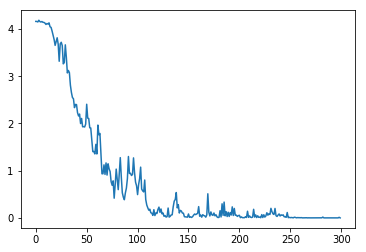

0%
0%
0%
1%
1%
1%
2%
2%
2%
3%
3%
3%
4%
4%
4%
5%
5%
5%
6%


In [ ]:
# test multiple prior init
nb_epochs =  300
batch_size = 50
model = NetLin(nb_hidden1, nb_hidden2, nb_hidden3, size_dataset)

nb_training = 3

for i in range(0,nb_training):
    for p in model.parameters(): p.data.normal_(0, 0.01)
    loss_plot = []
    train_model(model, train_input, train_target, loss_plot, nb_epochs, batch_size = batch_size)
    
    
    
    print(' train_error {:.02f}% test_error {:.02f}%'.format(
                compute_nb_errors(model, train_input, train_target, 20) / train_input.size(0) * 100,
                compute_nb_errors(model, test_input, test_target, 50) / test_input.size(0) * 100))
    #loss_plot
    for p in model.parameters(): p.data.normal_(0, 0.01)
    plt.plot(range(nb_epochs),loss_plot)
    plt.show()
    